# FWI in the Cloud with Devito

In [1]:
from google.cloud import storage

import os
from pathlib import Path

# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/ggorman/Downloads/seg-demo-project-2-2fa1703fb1c7.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/home/jovyan/seg-demo-project-2-2fa1703fb1c7.json"

def download_file_from_bucket(filename):    
    client = storage.Client(project='seg-demo-project-2')
    bucket = client.get_bucket('datasets-proxy')
    blob = bucket.get_blob(filename)
    with open(filename, 'wb') as f:
        blob.download_to_file(f)

def upload_file_to_bucket(filename):
    client = storage.Client(project='seg-demo-project-2')
    bucket = client.get_bucket('datasets-proxy')
    blob = storage.Blob(filename, bucket)
    with open(filename, 'rb') as f:
        blob.upload_from_file(f)

In [2]:
import h5py

def from_hdf5(filename, **kwargs):
    print("Open file")
    f = h5py.File(filename, 'r')
    
    print("Read origin")
    origin = kwargs.pop('origin', None)
    if origin is None:
        origin_key = kwargs.pop('origin_key', 'o')
        origin = tuple(f[origin_key][()])

    print("Read spacing")
    spacing = kwargs.pop('spacing', None)
    if spacing is None:
        spacing_key = kwargs.pop('spacing_key', 'd')
        spacing = tuple(f[spacing_key][()])
    
    print("Read nbpml")
    nbpml = kwargs.pop('nbpml', 20)
    datakey = kwargs.pop('datakey', None)
    if datakey is None:
        raise ValueError("datakey must be known - what is the name of the data in the file?")
    
    print("Read space_order")
    space_order=kwargs.pop('space_order', None)
    dtype = kwargs.pop('dtype', None)
    data_m = f[datakey][()]
    data_vp = np.sqrt(1/data_m).astype(dtype)
    data_vp = np.transpose(data_vp, (1, 2, 0))
    shape = data_vp.shape
    
    print("Close the file")
    f.close()
    
    print("Instantiate Model")
    
    return Model(space_order=space_order, vp=data_vp, origin=origin, shape=shape,
                 dtype=dtype, spacing=spacing, nbpml=nbpml)

In [3]:
#NBVAL_IGNORE_OUTPUT

# Set up inversion parameters.
param = {'t0': 0.,
         'tn': 4000.,              # Simulation last 4 second (4000 ms)
         'f0': 0.008,              # Source peak frequency is 5Hz (0.005 kHz)
         'nshots': 97**2,          # Number of shots to create gradient from
         'm_bounds': (0.08, 0.25), # Set the min and max slowness
         'nbpml': 40}              # nbpml thickness.

import numpy as np

import scipy
from scipy import signal, optimize

from devito import Grid

from distributed import Client, LocalCluster, wait

import cloudpickle as pickle

# Import acoustic solver, source and receiver modules.
from examples.seismic import Model, demo_model
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import TimeAxis, PointSource, RickerSource, Receiver

# Import convenience function for plotting results
from examples.seismic import plot_image

In [4]:
def get_true_model():
    filename = 'overthrust_3D_true_model.h5'
    
    model_file = Path(filename)
    if not model_file.is_file():
        download_file_from_bucket(filename)
        
    return from_hdf5(filename, nbpml=param['nbpml'], space_order=4,
                     datakey='m', dtype=np.float32)

In [5]:
true_model = get_true_model()

Open file
Read origin
Read spacing
Read nbpml
Read space_order
Close the file
Instantiate Model


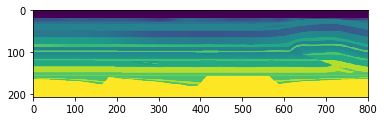

In [6]:
param['shape'] = true_model.vp.shape
param['spacing'] = true_model.spacing
param['origin'] = true_model.origin

import matplotlib.pyplot as plt
plt.imshow(true_model.vp[500, :, :].transpose())


In [7]:
def load_model(filename):
    """ Returns the current model. This is used by the
    worker to get the current model.
    """

    model_file = Path(filename)
    if not model_file.is_file():
        download_file_from_bucket(filename)

    pkl = pickle.load(open(filename, "rb"))
    
    return pkl['model']

def dump_model(filename, model):
    ''' Dump model to disk.
    '''
    pickle.dump({'model':model}, open(filename, "wb"))
    
    upload_file_to_bucket(filename)

In [8]:
def load_shot_data(shot_id, dt):
    ''' Load shot data from disk, resampling to the model time step.
    '''
    filename = "shot_%d.p"%shot_id
    model_file = Path(filename)
    if not model_file.is_file():
        download_file_from_bucket(filename)
    
    pkl = pickle.load(open(filename, "rb"))
    
    return pkl['src'].resample(dt), pkl['rec'].resample(dt)

def dump_shot_data(shot_id, src, rec):
    ''' Dump shot data to disk.
    '''
    filename = 'shot_%d.p'%shot_id
    pickle.dump({'src':src, 'rec':rec}, open(filename, "wb"))

    upload_file_to_bucket(filename)

In [9]:
def generate_shotdata_i(param):
    """ Inversion crime alert! Here the worker is creating the
        'observed' data using the real model. For a real case
        the worker would be reading seismic data from disk.
    """
    log = open("/log_%d.txt", 'w')
    
    log.write("get_true_model()")
    
    true_model = get_true_model()
    shot_id = param['shot_id']
    
    i = shot_id%97
    j = int(shot_id/97)
    
    # Time step from model grid spacing
    dt = true_model.critical_dt

    # Set up source data and geometry.
    log.write("Set up source data and geometry")
    time_range = TimeAxis(start=param['t0'], stop=param['tn'], step=dt)
    src = RickerSource(name='src', grid=true_model.grid, f0=param['f0'],
                       time_range=time_range)

    src.coordinates.data[0, :] = [400+i*true_model.spacing[0], 400+j*true_model.spacing[1], 50] 
    
    # Number of receiver locations per shot.
    nreceivers = 384**2

    # Set up receiver data and geometry.
    log.write("Set up receiver data and geometry.")
    rec = Receiver(name='rec', grid=true_model.grid, time_range=time_range,
                   npoint=nreceivers)
    
    for n in range(384):
        for m in range(384):
            rec.coordinates.data[:, 0] = 400+n*true_model.spacing[0]
            rec.coordinates.data[:, 1] = 400+m*true_model.spacing[1]
            rec.coordinates.data[:, 2] = 50

    # Set up solver.
    log.write("Set up solver.")
    solver = AcousticWaveSolver(true_model, src, rec, space_order=4)

    # Generate synthetic receiver data from true model.
    log.write("Generate synthetic receiver data from true model.")
    true_d, _, _ = solver.forward(src=src, m=true_model.m)

    log.write("dump_shot_data")
    dump_shot_data(shot_id, src, true_d)
    
    log.close()

def generate_shotdata(param):
    # Define work list
    work = [dict(param) for i in range(param['nshots'])]
    for i in  range(param['nshots']):
        work[i]['shot_id'] = i
        
    # Map worklist to cluster
    futures = client.map(generate_shotdata_i, work)
        
    # Wait for all futures
    wait(futures)

In [10]:
# Start Dask cluster
client = Client()

# Generate shot data.
generate_shotdata(param)